# Loans Classification

by André Antunes and Nuno Melo

The function `findspark.init()` makes pyspark importable as a regular library.

In [120]:
import findspark
findspark.init()

Build the Spark Session.

In [121]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate() 

## 1. Import the required libraries and packages.

In [122]:
from pyspark import SparkFiles

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer

from pyspark.sql.functions import isnan, when, count
from pyspark.sql.functions import col, explode, array, lit
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier, LinearSVC
from pyspark.ml.classification import GBTClassifier

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import classification_report 

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


## 2. Load the dataset

Read a csv file into a Spark dataframe.

In [123]:
dataset = spark.read.csv('grupo05.csv',header=True, sep=',', inferSchema=True)
dataset.show(5,vertical=True)


-RECORD 0--------------------------------------------
 ID                           | 17388503             
 Loan Amount                  | 12368                
 Funded Amount                | 23353                
 Funded Amount Investor       | 16997.29781          
 Term                         | 59                   
 Batch Enrolled               | BAT5924421           
 Interest Rate                | 17.37107461          
 Grade                        | C                    
 Sub Grade                    | C1                   
 Employment Duration          | MORTGAGE             
 Home Ownership               | 49456.48751          
 Verification Status          | Verified             
 Payment Plan                 | n                    
 Loan Title                   | Medical              
 Debit to Income              | 12.12823314          
 Delinquency - two years      | 0                    
 Inquires - six months        | 0                    
 Open Account               

## 3. Data Cleaning

Replace the spaces in attributes with underscore for easier use of attributes.

In [124]:
exprs = [col(column).alias(column.replace(' ', '_')) for column in dataset.columns]
dataset = dataset.select(*exprs)

Prints the dataset schema in the tree format.

In [125]:
dataset.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Loan_Amount: integer (nullable = true)
 |-- Funded_Amount: integer (nullable = true)
 |-- Funded_Amount_Investor: double (nullable = true)
 |-- Term: integer (nullable = true)
 |-- Batch_Enrolled: string (nullable = true)
 |-- Interest_Rate: double (nullable = true)
 |-- Grade: string (nullable = true)
 |-- Sub_Grade: string (nullable = true)
 |-- Employment_Duration: string (nullable = true)
 |-- Home_Ownership: double (nullable = true)
 |-- Verification_Status: string (nullable = true)
 |-- Payment_Plan: string (nullable = true)
 |-- Loan_Title: string (nullable = true)
 |-- Debit_to_Income: double (nullable = true)
 |-- Delinquency_-_two_years: integer (nullable = true)
 |-- Inquires_-_six_months: integer (nullable = true)
 |-- Open_Account: integer (nullable = true)
 |-- Public_Record: integer (nullable = true)
 |-- Revolving_Balance: integer (nullable = true)
 |-- Revolving_Utilities: double (nullable = true)
 |-- Total_Accounts: intege

Rename columns `Home_Ownership` and `Employment_Duration` that were swapped.

In [126]:
dataset = dataset.withColumnRenamed('Home_Ownership','Employment__Duration')\
                .withColumnRenamed('Employment_Duration','Home_Ownership')
dataset.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Loan_Amount: integer (nullable = true)
 |-- Funded_Amount: integer (nullable = true)
 |-- Funded_Amount_Investor: double (nullable = true)
 |-- Term: integer (nullable = true)
 |-- Batch_Enrolled: string (nullable = true)
 |-- Interest_Rate: double (nullable = true)
 |-- Grade: string (nullable = true)
 |-- Sub_Grade: string (nullable = true)
 |-- Home_Ownership: string (nullable = true)
 |-- Employment__Duration: double (nullable = true)
 |-- Verification_Status: string (nullable = true)
 |-- Payment_Plan: string (nullable = true)
 |-- Loan_Title: string (nullable = true)
 |-- Debit_to_Income: double (nullable = true)
 |-- Delinquency_-_two_years: integer (nullable = true)
 |-- Inquires_-_six_months: integer (nullable = true)
 |-- Open_Account: integer (nullable = true)
 |-- Public_Record: integer (nullable = true)
 |-- Revolving_Balance: integer (nullable = true)
 |-- Revolving_Utilities: double (nullable = true)
 |-- Total_Accounts: integ

Convert dataset to Pandas.

In [127]:
dataset_pd = dataset.toPandas()

We used the `shape` function to show the size of the *dataset*.<br>
There are 33 features and 27463 samples.

In [128]:
dataset_pd.shape

(27463, 33)

Information about the columns and their *data type* is displayed.

In [129]:
dataset_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27463 entries, 0 to 27462
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            27463 non-null  int32  
 1   Loan_Amount                   27463 non-null  int32  
 2   Funded_Amount                 27463 non-null  int32  
 3   Funded_Amount_Investor        27463 non-null  float64
 4   Term                          27463 non-null  int32  
 5   Batch_Enrolled                27463 non-null  object 
 6   Interest_Rate                 27449 non-null  float64
 7   Grade                         27463 non-null  object 
 8   Sub_Grade                     27463 non-null  object 
 9   Home_Ownership                27463 non-null  object 
 10  Employment__Duration          27463 non-null  float64
 11  Verification_Status           27463 non-null  object 
 12  Payment_Plan                  27463 non-null  object 
 13  L

View a description of all numeric columns in the dataset.

In [130]:
dataset_pd.describe()

,ID,Loan_Amount,Funded_Amount,Funded_Amount_Investor,Term,Interest_Rate,Employment__Duration,Debit_to_Income,Delinquency_-_two_years,Inquires_-_six_months,Open_Account,Public_Record,Revolving_Balance,Revolving_Utilities,Total_Accounts,Total_Received_Interest,Total_Received_Late_Fee,Recoveries,Collection_Recovery_Fee,Last_week_Pay,Total_Collection_Amount,Total_Current_Balance,Total_Revolving_Credit_Limit,Loan_Status
count,2.746300e+04,27463.000000,27463.000000,27463.000000,27463.000000,27449.000000,27463.000000,27463.000000,27463.000000,27463.000000,27463.000000,27463.000000,27463.000000,27463.000000,27463.000000,27463.000000,27463.000000,27463.000000,27463.000000,27463.000000,27463.000000,2.746300e+04,27463.000000,27463.000000
mean,2.560186e+07,16868.375123,15742.967957,14588.326348,58.164221,11.821836,80350.756825,23.343208,0.319011,0.148636,14.225540,0.083385,7658.492736,52.867355,18.659979,2068.683359,1.173008,61.605759,1.136185,71.209810,146.843717,1.594395e+05,23211.141317,0.091942
std,2.110842e+07,8401.265321,8110.971278,6734.715911,3.370217,3.708648,44755.246375,8.450867,0.777294,0.478938,6.229694,0.350881,7734.609834,22.581108,8.342639,2241.420311,5.319055,363.130016,3.633339,43.272842,757.330889,1.386522e+05,20989.369720,0.288949
min,1.298156e+06,1014.000000,1014.000000,1114.590204,36.000000,5.323846,14652.379680,1.237229,0.000000,0.000000,2.000000,0.000000,0.000000,0.005172,4.000000,4.736746,0.000023,0.000221,0.000184,0.000000,1.000000,6.910000e+02,1001.000000,0.000000
25%,6.545204e+06,9981.000000,9290.000000,9816.940246,58.000000,9.264274,51694.083320,16.765622,0.000000,0.000000,10.000000,0.000000,2552.000000,38.660499,13.000000,567.913021,0.021193,1.629009,0.475574,35.000000,24.000000,5.021600e+04,8172.000000,0.000000
50%,1.783361e+07,16087.000000,13031.000000,12797.867640,59.000000,11.346244,69232.089880,22.676667,0.000000,0.000000,13.000000,0.000000,5533.000000,54.155839,18.000000,1325.612301,0.043625,3.340969,0.779665,68.000000,35.000000,1.191580e+05,16811.000000,0.000000
75%,4.273982e+07,22193.000000,21711.500000,17701.515280,59.000000,14.187310,94404.906125,30.100717,0.000000,0.000000,16.000000,0.000000,10142.500000,69.069330,23.000000,2641.662551,0.072099,5.453965,1.066279,105.000000,46.000000,2.281755e+05,32149.000000,0.000000
max,7.218252e+07,35000.000000,34999.000000,34996.887470,59.000000,27.182348,404550.444000,39.629862,8.000000,5.000000,37.000000,4.000000,114621.000000,100.858613,72.000000,14301.368310,42.449040,4354.467419,166.833000,161.000000,16421.000000,1.177412e+06,201169.000000,1.000000


Show all columns.

In [131]:
pd.options.display.max_columns = dataset_pd.shape[1] 

View a description of all object columns in the dataset.

In [132]:
dataset_pd.describe(include=object)

,Batch_Enrolled,Grade,Sub_Grade,Home_Ownership,Verification_Status,Payment_Plan,Loan_Title,Initial_List_Status,Application_Type
count,27463,27463,27463,27463,27463,27463,27463,27463,27463
unique,41,7,35,3,3,1,108,2,2
top,BAT3873588,C,B4,MORTGAGE,Source Verified,n,Credit card refinancing,w,INDIVIDUAL
freq,1485,7768,1861,14723,13391,27463,12454,14838,27401


Check if there are NA values in each of the dataset attributes.

In [133]:
dataset_pd.isnull().sum()

ID                               0
Loan_Amount                      0
Funded_Amount                    0
Funded_Amount_Investor           0
Term                             0
Batch_Enrolled                   0
Interest_Rate                   14
Grade                            0
Sub_Grade                        0
Home_Ownership                   0
Employment__Duration             0
Verification_Status              0
Payment_Plan                     0
Loan_Title                       0
Debit_to_Income                  0
Delinquency_-_two_years          0
Inquires_-_six_months            0
Open_Account                     0
Public_Record                    0
Revolving_Balance                0
Revolving_Utilities              0
Total_Accounts                   0
Initial_List_Status              0
Total_Received_Interest          0
Total_Received_Late_Fee          0
Recoveries                       0
Collection_Recovery_Fee          0
Application_Type                 0
Last_week_Pay       

Drop all the rows that have NA values.

In [134]:
dataset_pd = dataset_pd.dropna()
print('Sum of NA values in Interest_Rate:',dataset_pd['Interest_Rate'].isnull().sum())

Sum of NA values in Interest_Rate: 0


Check how many unique values exist in the attributes.

In [135]:
dataset_pd.nunique()

ID                              27449
Loan_Amount                     17953
Funded_Amount                   16317
Funded_Amount_Investor          27448
Term                                3
Batch_Enrolled                     41
Interest_Rate                   27446
Grade                               7
Sub_Grade                          35
Home_Ownership                      3
Employment__Duration            27447
Verification_Status                 3
Payment_Plan                        1
Loan_Title                        108
Debit_to_Income                 27448
Delinquency_-_two_years             9
Inquires_-_six_months               6
Open_Account                       36
Public_Record                       5
Revolving_Balance               14068
Revolving_Utilities             27447
Total_Accounts                     67
Initial_List_Status                 2
Total_Received_Interest         27449
Total_Received_Late_Fee         27436
Recoveries                      27437
Collection_R

The attribute `Loan_Title` has many inconsistent values names. 

In [136]:
value_counts = dataset_pd['Loan_Title'].value_counts()
print(value_counts)

Credit card refinancing    12449
Debt consolidation         10057
Debt Consolidation          1458
Other                       1020
Home improvement             945
                           ...  
Personal loan                  2
Medical loan                   2
vacation                       2
Wedding Loan                   2
Credit                         1
Name: Loan_Title, Length: 108, dtype: int64


Find similar values names and send to a matching list.

In [137]:
debt_consolidation = dataset_pd[dataset_pd['Loan_Title'].str.startswith(('Consoli','consoli','debt','Debt','DEBT','Dept','CONSOL','Loan Consolidation','bill','Bill','pay','Pay','conso','Get Debt Free','get out of debt','Refi','refi','Green loan'))==True]['Loan_Title'].unique()
home = dataset_pd[dataset_pd['Loan_Title'].str.startswith(('Home','home','House'))==True]['Loan_Title'].unique()
credit = dataset_pd[dataset_pd['Loan_Title'].str.startswith(('Credit','CC','credit','Card','cards'))==True]['Loan_Title'].unique()
car_financing = dataset_pd[dataset_pd['Loan_Title'].str.contains('Car ')==True]['Loan_Title'].unique()
personal_loan = dataset_pd[dataset_pd['Loan_Title'].str.startswith(('Personal','personal','My'))==True]['Loan_Title'].unique()
medical_loan = dataset_pd[dataset_pd['Loan_Title'].str.startswith(('Med','med'))==True]['Loan_Title'].unique()
other_loan = dataset_pd[dataset_pd['Loan_Title'].str.startswith(('Loan','Free','Bath','loan','Lending','MYLOAN','relief','Getting Ahead','Pool','Wedding Loan'))==True]['Loan_Title'].unique()
vacation = dataset_pd[dataset_pd['Loan_Title'].str.startswith('vacation')==True]['Loan_Title'].unique()

Replace name values with general name.

In [138]:
for c in debt_consolidation:
    dataset_pd['Loan_Title'].replace(c,'Debt Consolidation',inplace=True)
for h in home:    
    dataset_pd['Loan_Title'].replace(h,'Home Loan',inplace=True)
for c in credit:    
    dataset_pd['Loan_Title'].replace(c,'Credit Card Loan',inplace=True)   
for c in car_financing:    
    dataset_pd['Loan_Title'].replace(c,'Car Financing',inplace=True) 
for p in personal_loan:    
    dataset_pd['Loan_Title'].replace(p,'Personal Loan',inplace=True) 
for m in medical_loan:
    dataset_pd['Loan_Title'].replace(m,'Medical Loan',inplace=True)
for o in other_loan:
    dataset_pd['Loan_Title'].replace(o,'Others',inplace=True)
for v in vacation:
    dataset_pd['Loan_Title'].replace(v,'Vacation',inplace=True)

The attribute `Loan_Title` has now only 12 values names. 

In [139]:
value_counts = dataset_pd['Loan_Title'].nunique()
print(value_counts)

12


The attribute `Payment_Plan` has a unique value.

In [140]:
payment_plane_unique = dataset_pd['Payment_Plan'].unique()
print(f'Payment_Plan unique value: {payment_plane_unique}')

Payment_Plan unique value: ['n']


Drop `ID` and `Payment_Plan` attributes.

In [141]:
dataset_pd = dataset_pd.drop(['ID','Payment_Plan'], axis=1)

## 4. Exploratory Data Analysis

Color palette to use.

In [142]:
sns.set_palette(['#0099ff','#006bb3','#003d66'])

Correlation between all attributes.

In [143]:
dataset_pd.corr()

,Loan_Amount,Funded_Amount,Funded_Amount_Investor,Term,Interest_Rate,Employment__Duration,Debit_to_Income,Delinquency_-_two_years,Inquires_-_six_months,Open_Account,Public_Record,Revolving_Balance,Revolving_Utilities,Total_Accounts,Total_Received_Interest,Total_Received_Late_Fee,Recoveries,Collection_Recovery_Fee,Last_week_Pay,Total_Collection_Amount,Total_Current_Balance,Total_Revolving_Credit_Limit,Loan_Status
Loan_Amount,1.000000,0.001487,0.005562,0.004426,-0.001839,0.016196,0.005976,-0.005207,0.011838,0.012302,-0.004593,-0.003153,0.022875,0.002046,-0.006127,0.005311,-0.001279,-0.003177,-0.001745,-0.003200,-0.010527,0.003106,-0.010354
Funded_Amount,0.001487,1.000000,0.016001,-0.001693,0.004867,-0.007821,0.002547,0.014373,-0.007791,0.001532,0.004317,-0.005093,0.005498,0.002477,0.003288,0.007350,0.007617,-0.000281,-0.000791,0.008099,-0.010759,0.002588,-0.002105
Funded_Amount_Investor,0.005562,0.016001,1.000000,-0.008258,-0.002412,-0.005348,0.001473,0.004243,-0.000937,-0.010765,0.008669,-0.010108,-0.005211,-0.000516,0.001204,0.002537,0.001113,-0.012142,0.003909,0.004853,0.000476,0.010868,-0.005927
Term,0.004426,-0.001693,-0.008258,1.000000,-0.029173,-0.023831,0.004121,-0.003635,-0.003221,0.025559,0.000138,-0.000220,-0.012066,0.004426,0.010703,-0.006110,-0.020829,-0.008659,0.010249,-0.002444,0.002283,-0.003773,-0.001224
Interest_Rate,-0.001839,0.004867,-0.002412,-0.029173,1.000000,-0.000053,-0.008539,0.010869,0.008795,-0.001318,0.007422,0.026364,0.001908,0.001799,0.011286,0.004238,0.009209,0.002108,-0.010905,0.000297,-0.001005,0.019041,0.003304
Employment__Duration,0.016196,-0.007821,-0.005348,-0.023831,-0.000053,1.000000,0.017417,-0.003107,-0.001417,0.012904,0.002113,0.017532,-0.004059,0.032562,-0.011855,0.004293,-0.000535,-0.003965,-0.008658,0.007839,0.012501,0.011186,0.008158
Debit_to_Income,0.005976,0.002547,0.001473,0.004121,-0.008539,0.017417,1.000000,-0.004955,0.002310,0.005237,-0.001985,-0.008371,0.010379,-0.005093,0.013966,-0.006760,-0.004447,-0.000323,0.009099,0.000785,-0.019958,-0.010396,-0.000631
Delinquency_-_two_years,-0.005207,0.014373,0.004243,-0.003635,0.010869,-0.003107,-0.004955,1.000000,0.006346,0.011712,0.003322,0.019543,-0.001337,-0.000944,0.003550,0.009934,0.017809,0.007405,-0.001458,0.001419,-0.007537,0.013561,0.012758
Inquires_-_six_months,0.011838,-0.007791,-0.000937,-0.003221,0.008795,-0.001417,0.002310,0.006346,1.000000,-0.007986,0.001471,0.000545,0.008476,0.010038,0.011622,0.008764,0.009557,0.003748,-0.009078,-0.002954,0.001739,0.004448,0.007419
Open_Account,0.012302,0.001532,-0.010765,0.025559,-0.001318,0.012904,0.005237,0.011712,-0.007986,1.000000,-0.015691,0.010100,0.008146,0.003428,0.013349,0.005938,-0.002015,-0.007998,-0.016188,0.000099,-0.010596,0.003642,-0.011002


Uses a heatmap to visualize correlations between attributes.

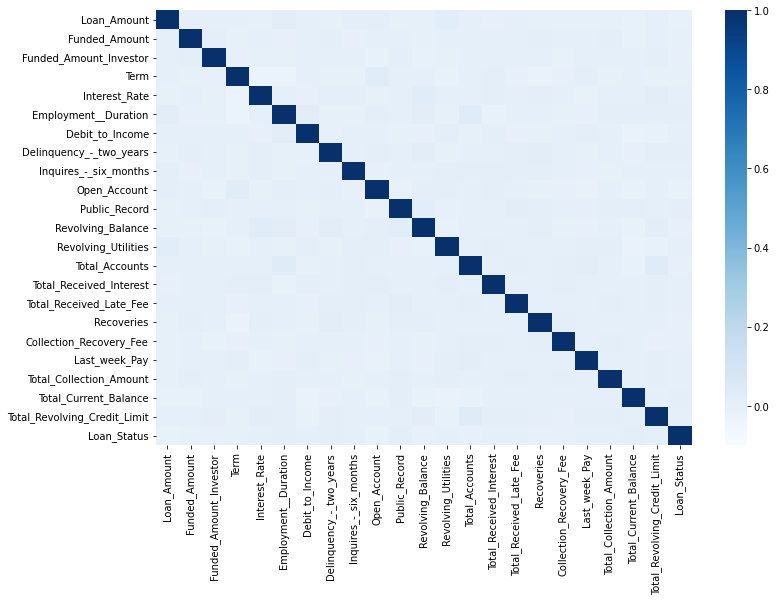

In [144]:
plt.figure(figsize=(12,8))
sns_plot = sns.heatmap(dataset_pd.corr(), vmin=-0.1, vmax=1,annot=False, cmap='Blues')
sns_plot.figure.savefig('heatmap.png')

Distribution of `Grades` by `Home_Ownership`.

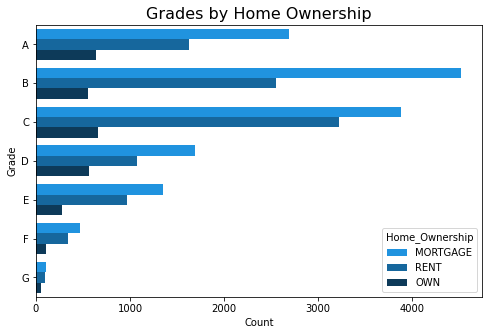

In [145]:
plt.figure(figsize = (8,5))
plt.title('Grades by Home Ownership', fontsize = "16")
sns.countplot(y="Grade", hue="Home_Ownership", order=['A','B','C','D','E','F','G'], data=dataset_pd)
plt.xlabel('Count')
plt.ylabel('Grade')
plt.show()

Distribution of `Grades` by `Loan_Status`.

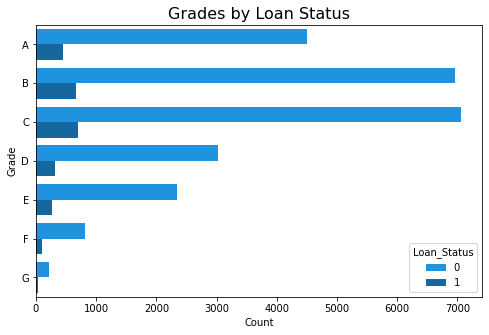

In [146]:
plt.figure(figsize = (8,5))
plt.title('Grades by Loan Status', fontsize = "16")
sns.countplot(y="Grade", hue="Loan_Status", order=['A','B','C','D','E','F','G'], data=dataset_pd)
plt.xlabel('Count')
plt.ylabel('Grade')
plt.show()

Piechart of `Verification_Status`.

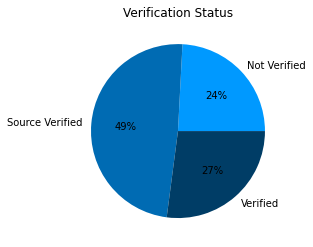

In [147]:
dataset_pd.groupby('Verification_Status').size().plot(kind='pie', title='Verification Status', autopct='%.0f%%')
plt.axis('off')
plt.savefig('piechart.png')

Number of values in `Verification_Status`.

In [148]:
dataset_pd['Verification_Status'].value_counts()

Source Verified    13383
Verified            7431
Not Verified        6635
Name: Verification_Status, dtype: int64

Replace 'Source Verified' with 'Verified'.

In [149]:
dataset_pd['Verification_Status'].replace('Source Verified','Verified',inplace=True)

Number of values in `Verification_Status` after changes.

In [150]:
dataset_pd['Verification_Status'].value_counts()

Verified        20814
Not Verified     6635
Name: Verification_Status, dtype: int64

Number of values in `Verification_Status` after changes on a piechart.

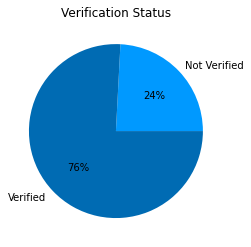

In [151]:
dataset_pd.groupby('Verification_Status').size().plot(kind='pie', title='Verification Status', autopct='%.0f%%')
plt.axis('off')
plt.savefig('piechart.png')

Boxplot of `Loan_Amount` by `Loan_Title`.

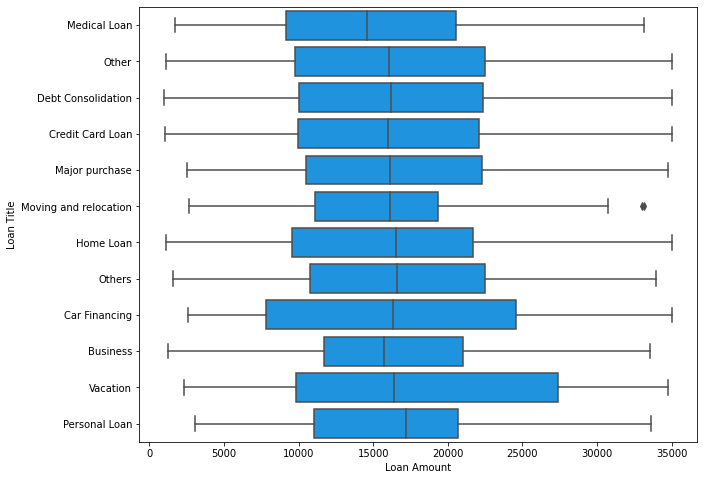

In [152]:
plt.figure(figsize = (10,8))
sns.boxplot(x='Loan_Amount', y='Loan_Title', data=dataset_pd, color='#0099ff', orient='h')
plt.xlabel('Loan Amount')
plt.ylabel('Loan Title')
plt.show()

Boxplot of `Loan_Amount`.

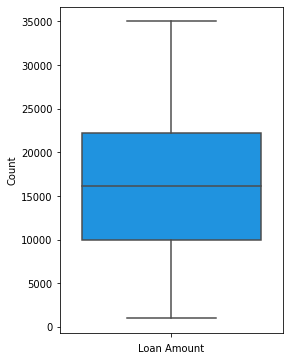

In [153]:
plt.figure(figsize = (4,6))
sns.boxplot(y='Loan_Amount', data=dataset_pd, color='#0099ff')
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.show()

Boxplot of `Application_Type` by `Loan_Amount`.

<AxesSubplot:xlabel='Application_Type', ylabel='Loan_Amount'>

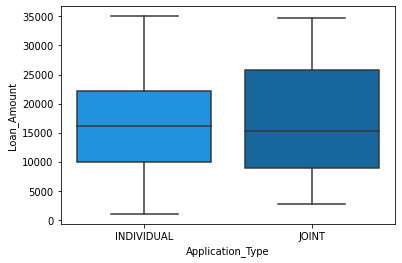

In [154]:
sns.boxplot(x='Application_Type', y='Loan_Amount', data=dataset_pd)

Value counts of the target `Loan_Status`.

In [155]:
dataset_pd['Loan_Status'].value_counts()

0    24926
1     2523
Name: Loan_Status, dtype: int64

A bar chart of the Non Defaulters vs. Defaulters (Non Defaulter = 0, Defaulter = 1)

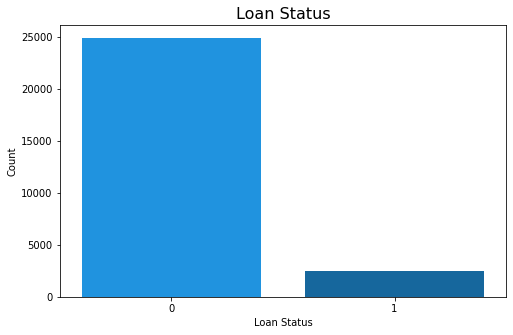

In [156]:
plt.figure(figsize = (8,5))
plt.title('Loan Status', fontsize = "16")
sns.countplot(x = 'Loan_Status', data = dataset_pd)
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

Select categorical attributes and put them in a list.

In [157]:
categorical_columns = dataset_pd.select_dtypes(include=object).columns.tolist()
categorical_columns

['Batch_Enrolled',
 'Grade',
 'Sub_Grade',
 'Home_Ownership',
 'Verification_Status',
 'Loan_Title',
 'Initial_List_Status',
 'Application_Type']

The LabelEncoder converts each value in a categorical column into a numerical value.

In [158]:
le= LabelEncoder()

for col in categorical_columns:
    dataset_pd[col] = le.fit_transform(dataset_pd[col])

In [159]:
dataset_pd.head()

,Loan_Amount,Funded_Amount,Funded_Amount_Investor,Term,Batch_Enrolled,Interest_Rate,Grade,Sub_Grade,Home_Ownership,Employment__Duration,Verification_Status,Loan_Title,Debit_to_Income,Delinquency_-_two_years,Inquires_-_six_months,Open_Account,Public_Record,Revolving_Balance,Revolving_Utilities,Total_Accounts,Initial_List_Status,Total_Received_Interest,Total_Received_Late_Fee,Recoveries,Collection_Recovery_Fee,Application_Type,Last_week_Pay,Total_Collection_Amount,Total_Current_Balance,Total_Revolving_Credit_Limit,Loan_Status
0,12368,23353,16997.297810,59,40,17.371075,2,10,0,49456.48751,1,6,12.128233,0,0,12,0,4755,32.426285,26,1,1261.664743,0.092564,4.494961,0.658580,0,15,17,110910,28538,0
1,12622,26273,12185.938190,59,18,5.514894,5,4,2,89132.96235,0,8,24.683526,0,0,13,0,15003,70.224720,35,1,4840.606716,0.006874,1.845878,0.844812,0,26,6,319982,14930,0
2,4728,9827,11289.689940,58,0,10.910055,0,4,1,71210.30509,1,8,22.347563,0,0,13,0,6103,30.033721,42,0,2225.175608,0.134725,5.224270,0.280217,0,136,23,155286,19483,0
3,27493,16144,7611.422039,58,27,10.154038,0,18,1,121574.02920,0,3,7.988375,0,0,11,0,3858,8.466361,25,0,19.631548,0.019703,0.606444,0.209944,0,62,34,259609,39157,0
4,21095,13706,16966.260780,59,18,12.527165,1,20,0,73015.69347,1,2,13.249020,0,0,13,0,3190,81.842406,19,1,646.127838,0.011499,7.934989,0.672915,0,88,26,151563,17724,0


## 5. Machine Learning Algorithms

Convert dataset_pd to PySpark.

In [160]:
dataset = spark.createDataFrame(dataset_pd)
dataset.show()

+-----------+-------------+----------------------+----+--------------+-------------+-----+---------+--------------+--------------------+-------------------+----------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+-----------+-----------------------+----------------+-------------+-----------------------+---------------------+----------------------------+-----------+
|Loan_Amount|Funded_Amount|Funded_Amount_Investor|Term|Batch_Enrolled|Interest_Rate|Grade|Sub_Grade|Home_Ownership|Employment__Duration|Verification_Status|Loan_Title|Debit_to_Income|Delinquency_-_two_years|Inquires_-_six_months|Open_Account|Public_Record|Revolving_Balance|Revolving_Utilities|Total_Accounts|Initial_List_Status|Total_Received_Interest|Total_Received_Late_Fee| Recoveries|Collection_Recovery_Fee|Application_Type|Last_week_Pay|Total_Collection_Amount|

Prints the dataset schema in the tree format.

In [161]:
dataset.printSchema()

root
 |-- Loan_Amount: long (nullable = true)
 |-- Funded_Amount: long (nullable = true)
 |-- Funded_Amount_Investor: double (nullable = true)
 |-- Term: long (nullable = true)
 |-- Batch_Enrolled: long (nullable = true)
 |-- Interest_Rate: double (nullable = true)
 |-- Grade: long (nullable = true)
 |-- Sub_Grade: long (nullable = true)
 |-- Home_Ownership: long (nullable = true)
 |-- Employment__Duration: double (nullable = true)
 |-- Verification_Status: long (nullable = true)
 |-- Loan_Title: long (nullable = true)
 |-- Debit_to_Income: double (nullable = true)
 |-- Delinquency_-_two_years: long (nullable = true)
 |-- Inquires_-_six_months: long (nullable = true)
 |-- Open_Account: long (nullable = true)
 |-- Public_Record: long (nullable = true)
 |-- Revolving_Balance: long (nullable = true)
 |-- Revolving_Utilities: double (nullable = true)
 |-- Total_Accounts: long (nullable = true)
 |-- Initial_List_Status: long (nullable = true)
 |-- Total_Received_Interest: double (nullable =

Combine *features* in a vector.

In [162]:
vector_assembler = VectorAssembler(inputCols=['Loan_Amount','Funded_Amount','Funded_Amount_Investor',
                                              'Term','Batch_Enrolled','Interest_Rate','Grade','Sub_Grade',
                                              'Home_Ownership','Employment__Duration','Verification_Status',
                                              'Loan_Title','Debit_to_Income','Delinquency_-_two_years',
                                              'Inquires_-_six_months','Open_Account','Public_Record',
                                              'Revolving_Balance','Revolving_Utilities','Total_Accounts',
                                              'Initial_List_Status','Total_Received_Interest',
                                              'Total_Received_Late_Fee','Recoveries','Collection_Recovery_Fee',
                                              'Application_Type','Last_week_Pay','Total_Collection_Amount',
                                              'Total_Current_Balance','Total_Revolving_Credit_Limit']
                                             ,outputCol="features")
output = vector_assembler.transform(dataset)
output.show(5)

+-----------+-------------+----------------------+----+--------------+-------------+-----+---------+--------------+--------------------+-------------------+----------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+-----------+-----------------------+----------------+-------------+-----------------------+---------------------+----------------------------+-----------+--------------------+
|Loan_Amount|Funded_Amount|Funded_Amount_Investor|Term|Batch_Enrolled|Interest_Rate|Grade|Sub_Grade|Home_Ownership|Employment__Duration|Verification_Status|Loan_Title|Debit_to_Income|Delinquency_-_two_years|Inquires_-_six_months|Open_Account|Public_Record|Revolving_Balance|Revolving_Utilities|Total_Accounts|Initial_List_Status|Total_Received_Interest|Total_Received_Late_Fee| Recoveries|Collection_Recovery_Fee|Application_Type|Last_week_Pay|Tot

Standardizes the data.

In [163]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

scalerModel = scaler.fit(output).transform(output)

scalerModel.select("features","scaledFeatures").show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[12368.0,23353.0,...|[1.47212500680719...|
|[12622.0,26273.0,...|[1.50235784572448...|
|[4728.0,9827.0,11...|[0.56275930079110...|
|[27493.0,16144.0,...|[3.27240724548433...|
|[21095.0,13706.0,...|[2.51087298015829...|
+--------------------+--------------------+
only showing top 5 rows



Distribution of classes in the target attribute `Loan_Status`.

In [164]:
scalerModel.groupBy('Loan_Status').count().show()

+-----------+-----+
|Loan_Status|count|
+-----------+-----+
|          0|24926|
|          1| 2523|
+-----------+-----+



Ratio between the largest class and the smallest class in target `Loan_Status`.

In [165]:
from pyspark.sql.functions import col
major_df = scalerModel.filter(col("Loan_Status") == 0)
major_df
minor_df = scalerModel.filter(col("Loan_Status") == 1)
minor_df
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 9


Method of major class undersampling. 

In [166]:
sampled_majority_df = major_df.sample(False, 1/ratio)
combined_df = sampled_majority_df.unionAll(minor_df)
scalerModel = combined_df
scalerModel.show(5)

+-----------+-------------+----------------------+----+--------------+-------------+-----+---------+--------------+--------------------+-------------------+----------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+-----------+-----------------------+----------------+-------------+-----------------------+---------------------+----------------------------+-----------+--------------------+--------------------+
|Loan_Amount|Funded_Amount|Funded_Amount_Investor|Term|Batch_Enrolled|Interest_Rate|Grade|Sub_Grade|Home_Ownership|Employment__Duration|Verification_Status|Loan_Title|Debit_to_Income|Delinquency_-_two_years|Inquires_-_six_months|Open_Account|Public_Record|Revolving_Balance|Revolving_Utilities|Total_Accounts|Initial_List_Status|Total_Received_Interest|Total_Received_Late_Fee| Recoveries|Collection_Recovery_Fee|Application_T

Put in a new dataset final_data `scaledFeatures` and `Loan_Status`.

In [167]:
final_data = scalerModel.select("scaledFeatures","Loan_Status")
final_data.show(5)

+--------------------+-----------+
|      scaledFeatures|Loan_Status|
+--------------------+-----------+
|[0.56275930079110...|          0|
|[2.05452375020205...|          0|
|[1.77933349989980...|          0|
|[2.63763665514614...|          0|
|[3.60449236587503...|          0|
+--------------------+-----------+
only showing top 5 rows



Check if classes are balanced.

In [168]:
final_data.groupBy('Loan_Status').count().show()

+-----------+-----+
|Loan_Status|count|
+-----------+-----+
|          0| 2843|
|          1| 2523|
+-----------+-----+



Train test split with 70% for training and 30% for the test.

In [169]:
train, test = final_data.randomSplit([0.70, 0.30])
print("training dataset:", str(train.count()))
print("test dataset:", str(test.count()))

training dataset: 3726
test dataset: 1640


Applying the Logistic Regression algorithm with 10 maximum iteracions.

In [170]:
lr = LogisticRegression(featuresCol = "scaledFeatures",labelCol="Loan_Status", maxIter=10)
lrModel = lr.fit(train)
predict_train=lrModel.transform(train)
predict_test=lrModel.transform(test)

Score for training and test.

In [171]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="Loan_Status")
predict_test.select("Loan_Status","rawPrediction").show(5)

print("Train score {}".format(evaluator.evaluate(predict_train)))
print("Test score {}".format(evaluator.evaluate(predict_test)))

+-----------+--------------------+
|Loan_Status|       rawPrediction|
+-----------+--------------------+
|          0|[-0.0767393653309...|
|          0|[-0.0239822021585...|
|          0|[-0.1540125153158...|
|          0|[-0.0837564836540...|
|          0|[-0.0047116931921...|
+-----------+--------------------+
only showing top 5 rows

Train score 0.5668344426256697
Test score 0.545735037628471


Classification report with all metrics.

In [172]:
print(classification_report(test.select('Loan_Status').toPandas(),predict_test.select('prediction').toPandas()))

              precision    recall  f1-score   support

           0       0.59      0.63      0.61       918
           1       0.48      0.44      0.46       722

    accuracy                           0.55      1640
   macro avg       0.54      0.53      0.53      1640
weighted avg       0.54      0.55      0.54      1640



Predictions and labels to use confusion matrix.

In [173]:
preds_and_labels = predict_test.select(['prediction','Loan_Status']).withColumn('Loan_Status', F.col('Loan_Status').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','Loan_Status'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
array = metrics.confusionMatrix().toArray()
print(array)

C:\spark\spark-3.2.0-bin-hadoop3.2\python\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[581. 337.]
 [407. 315.]]


Show confusion matrix with labels and title.

Text(0.5, 15.0, 'Predicted label')

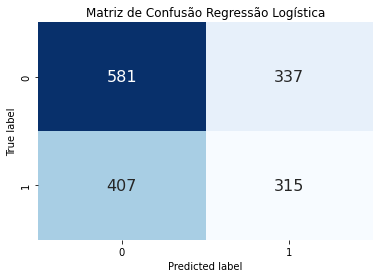

In [174]:
sns.heatmap(array, annot=True, cbar = None, annot_kws={"size": 16}, fmt = ".0f", cmap='Blues')
plt.title('Matriz de Confusão Regressão Logística')
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Random Forest

String Indexer of `Loan_Status`.

In [175]:
stringIndexer = StringIndexer(inputCol = 'Loan_Status', outputCol = 'labelIndexed')
inputDF = stringIndexer.fit(output).transform(output)

Ratio between the largest class and the smallest class in target `Loan_Status`.

In [176]:
from pyspark.sql.functions import col, explode, array, lit

major_df = inputDF.filter(col("Loan_Status") == 0)
major_df
minor_df = inputDF.filter(col("Loan_Status") == 1)
minor_df
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 9


Method of major class undersampling. 

In [177]:
sampled_majority_df = major_df.sample(False, 1/ratio)
combined_df_2 = sampled_majority_df.unionAll(minor_df)
scalerModel = combined_df_2
scalerModel.show(5)

+-----------+-------------+----------------------+----+--------------+-------------+-----+---------+--------------+--------------------+-------------------+----------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+-----------+-----------------------+----------------+-------------+-----------------------+---------------------+----------------------------+-----------+--------------------+------------+
|Loan_Amount|Funded_Amount|Funded_Amount_Investor|Term|Batch_Enrolled|Interest_Rate|Grade|Sub_Grade|Home_Ownership|Employment__Duration|Verification_Status|Loan_Title|Debit_to_Income|Delinquency_-_two_years|Inquires_-_six_months|Open_Account|Public_Record|Revolving_Balance|Revolving_Utilities|Total_Accounts|Initial_List_Status|Total_Received_Interest|Total_Received_Late_Fee| Recoveries|Collection_Recovery_Fee|Application_Type|Last

Select features and target `labelIndexed`.

In [178]:
final_data2 = scalerModel.select("features","labelIndexed")
final_data2.show(5)

+--------------------+------------+
|            features|labelIndexed|
+--------------------+------------+
|[17703.0,26995.0,...|         0.0|
|[12398.0,13265.0,...|         0.0|
|[9979.0,8770.0,67...|         0.0|
|[3719.0,1931.0,12...|         0.0|
|[12408.0,6729.0,6...|         0.0|
+--------------------+------------+
only showing top 5 rows



Check if classes are balanced.

In [179]:
final_data2.groupBy('labelIndexed').count().show()

+------------+-----+
|labelIndexed|count|
+------------+-----+
|         0.0| 2746|
|         1.0| 2523|
+------------+-----+



Train test split with 70% for training and 30% for the test.

In [180]:
train, test = final_data2.randomSplit([0.7, 0.3],seed=1000)
print("training dataset:", str(train.count()))
print("test dataset:", str(test.count()))

training dataset: 3705
test dataset: 1564


Applying the Random Forest algorithm.

In [181]:
random_forest = RandomForestClassifier(featuresCol='features', labelCol='labelIndexed')
rfModel = random_forest.fit(train)
predictions = rfModel.transform(test)
predictions.select("prediction", 'labelIndexed').show(5)

+----------+------------+
|prediction|labelIndexed|
+----------+------------+
|       0.0|         0.0|
|       0.0|         0.0|
|       1.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
+----------+------------+
only showing top 5 rows



Observe importance of all features.

In [182]:
rfModel.featureImportances

SparseVector(30, {0: 0.035, 1: 0.0656, 2: 0.0534, 3: 0.0145, 4: 0.0634, 5: 0.0258, 6: 0.0082, 7: 0.0572, 8: 0.0074, 9: 0.0414, 10: 0.0044, 11: 0.0084, 12: 0.0343, 13: 0.0131, 14: 0.0092, 15: 0.0304, 16: 0.0105, 17: 0.0383, 18: 0.0612, 19: 0.0406, 20: 0.0078, 21: 0.0324, 22: 0.0355, 23: 0.0596, 24: 0.0571, 25: 0.0017, 26: 0.0424, 27: 0.0567, 28: 0.046, 29: 0.0384})

Accuracy and test error.

In [183]:
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndexed", predictionCol='prediction', metricName='accuracy')

accuracy = evaluator.evaluate(predictions)

print(f"Accuracy = {round(accuracy*100,1)} %")
print(f"Test Error = {round((1.0 - accuracy)*100,1)} % ")

Accuracy = 51.6 %
Test Error = 48.4 % 


Classification report with all metrics.

In [184]:
print(classification_report(test.select('labelIndexed').toPandas(),predictions.select('prediction').toPandas()))

              precision    recall  f1-score   support

         0.0       0.53      0.76      0.62       816
         1.0       0.49      0.25      0.33       748

    accuracy                           0.52      1564
   macro avg       0.51      0.51      0.48      1564
weighted avg       0.51      0.52      0.48      1564



Predictions and labels to use confusion matrix.

In [185]:
preds_and_labels = predictions.select(['prediction','labelIndexed']).withColumn('labelIndexed', F.col('labelIndexed').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','labelIndexed'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
array = metrics.confusionMatrix().toArray()
print(array)

C:\spark\spark-3.2.0-bin-hadoop3.2\python\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[618. 198.]
 [559. 189.]]


Show confusion matrix with labels and title.

Text(0.5, 15.0, 'Predicted label')

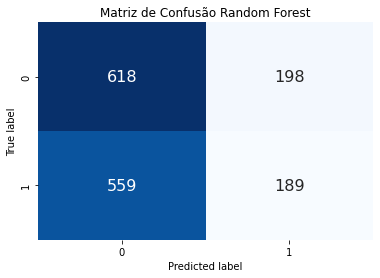

In [186]:
sns.heatmap(array, annot=True, cbar = None, annot_kws={"size": 16}, fmt = ".0f", cmap='Blues')
plt.title('Matriz de Confusão Random Forest')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Other algorithms were also implemented but without improvements compared to the previous ones.

## Naive Bayes

Train test split with 70% for training and 30% for the test.

In [187]:
train, test = final_data2.randomSplit([0.7, 0.3],seed=1000)
print("training dataset:", str(train.count()))
print("test dataset:", str(test.count()))

training dataset: 3705
test dataset: 1564


Check if classes are balanced.

In [188]:
final_data2.groupBy('labelIndexed').count().show()

+------------+-----+
|labelIndexed|count|
+------------+-----+
|         0.0| 2746|
|         1.0| 2523|
+------------+-----+



Applying the Naive Bayes algorithm.

In [189]:
nb = NaiveBayes(featuresCol = "features",labelCol="labelIndexed", modelType="multinomial")
nbmodel = nb.fit(train)
predictions_df = nbmodel.transform(test)
predictions_df.show(5)

+--------------------+------------+--------------------+--------------------+----------+
|            features|labelIndexed|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|[2543.0,6888.0,22...|         0.0|[-399543.35033469...|[1.25540870679709...|       1.0|
|[3563.0,17630.0,1...|         0.0|[-250590.48358839...|           [1.0,0.0]|       0.0|
|[3719.0,1931.0,12...|         0.0|[-425010.19059420...|           [0.0,1.0]|       1.0|
|[4190.0,12882.0,1...|         0.0|[-406185.85670542...|           [0.0,1.0]|       1.0|
|[4372.0,14138.0,1...|         0.0|[-416390.45332071...|           [0.0,1.0]|       1.0|
+--------------------+------------+--------------------+--------------------+----------+
only showing top 5 rows



Accuracy and test error.

In [190]:
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndexed", predictionCol="prediction", metricName="accuracy")
nbaccuracy = evaluator.evaluate(predictions_df)
print("Test set accuracy = ", str(nbaccuracy))

Test set accuracy =  0.5


## Gradient Boosting

Applying the Gradient Boosting algorithm.

In [191]:
gbt = GBTClassifier(featuresCol = "features",labelCol="labelIndexed",maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('prediction', 'labelIndexed').show(10)

+----------+------------+
|prediction|labelIndexed|
+----------+------------+
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       1.0|         0.0|
|       1.0|         0.0|
+----------+------------+
only showing top 10 rows



Test area under ROC.

In [192]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="labelIndexed")
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.49157065901226793


## SVM

Train test split with 70% for training and 30% for the test.

In [193]:
train, test = final_data2.randomSplit([0.7, 0.3],seed=1000)
print("training dataset:", str(train.count()))
print("test dataset:", str(test.count()))

training dataset: 3705
test dataset: 1564


Applying the SVM algorithm.

In [194]:
lsvc = LinearSVC(featuresCol = "features",labelCol="labelIndexed",maxIter=10, regParam=0.1)
lsvcModel = lsvc.fit(train)
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

Coefficients: [4.248521218628283e-06,-6.876948339043385e-06,-5.4865355792873164e-06,-0.004747427611226675,-0.00748473808823967,-0.0003362519679523572,0.04595552031298293,0.0053081409542947424,0.014934582982120713,3.3556359129170377e-07,-0.09458717387783662,0.01187384754745671,-0.002043931393352727,0.0989207190947006,0.12921944431748125,-0.0034248889166192914,0.4131475162488599,-2.3630710978099786e-07,-0.0037984819437443997,-0.001985236677044179,-0.11146694310755831,6.686001887135077e-06,0.01581378070529258,1.789639365044551e-05,-0.006394759616376931,1.1709052796769825,-1.5047360866719533e-05,4.37582020716675e-05,5.325820949297842e-07,2.5388101052248422e-06]
Intercept: -0.1153215311308522


Test area under ROC.

In [195]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="labelIndexed")
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.491570659012268


Classification report with all metrics.

In [196]:
print(classification_report(test.select('labelIndexed').toPandas(),predictions.select('prediction').toPandas()))

              precision    recall  f1-score   support

         0.0       0.52      0.57      0.54       816
         1.0       0.47      0.43      0.45       748

    accuracy                           0.50      1564
   macro avg       0.50      0.50      0.50      1564
weighted avg       0.50      0.50      0.50      1564

